In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import pandas as pd
from tqdm.notebook import tqdm
import copy
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# seed for reproducibility across all libraries
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [4]:
def make_moons_custom(n_samples=100, noise=0.0):
    # number of samples for each moon
    n_samples_outer = n_samples // 2
    n_samples_inner = n_samples - n_samples_outer

    # class 0 (semi circle centered at (0,0))
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_outer))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_outer))

    # class 1 (semi circle centered at (1, 0.5) and flipped)
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_inner))
    inner_circ_y = 0.5 - np.sin(np.linspace(0, np.pi, n_samples_inner))

    # concatenate
    X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                   np.append(outer_circ_y, inner_circ_y)]).T
    y = np.hstack([np.zeros(n_samples_outer), np.ones(n_samples_inner)])

    # add gaussian noise (the noise parameter controls the standard deviation of this noise)
    if noise is not None:
        X += np.random.normal(scale=noise, size=X.shape)

    return X, y.astype(int)

In [5]:
# as specified we need one training set and three test sets with different noise levels.
# noise 0.2
X_train_raw, y_train_raw = make_moons_custom(n_samples=500, noise=0.2)

# (low noise) for robustness check
X_test_01, y_test_01 = make_moons_custom(n_samples=500, noise=0.1)

# (default noise) for primary evaluation
X_test_02, y_test_02 = make_moons_custom(n_samples=500, noise=0.2)

# (high noise) for robustness check
X_test_03, y_test_03 = make_moons_custom(n_samples=500, noise=0.3)

print(f"Shape of raw training X: {X_train_raw.shape}")
print(f"Shape of raw training y: {y_train_raw.shape}")

Shape of raw training X: (500, 2)
Shape of raw training y: (500,)


In [6]:
X_train_raw[:10]

array([[ 0.85936254, -0.09805647],
       [ 0.93555754, -0.33839924],
       [ 1.04101454, -0.37702192],
       [ 0.88783361,  0.10528488],
       [ 1.30849399, -0.22370138],
       [ 1.28306913,  0.00714957],
       [ 0.88521046,  0.31290542],
       [ 1.33580629, -0.25004093],
       [ 0.85500585,  0.21735598],
       [ 1.18920447, -0.13016674]])

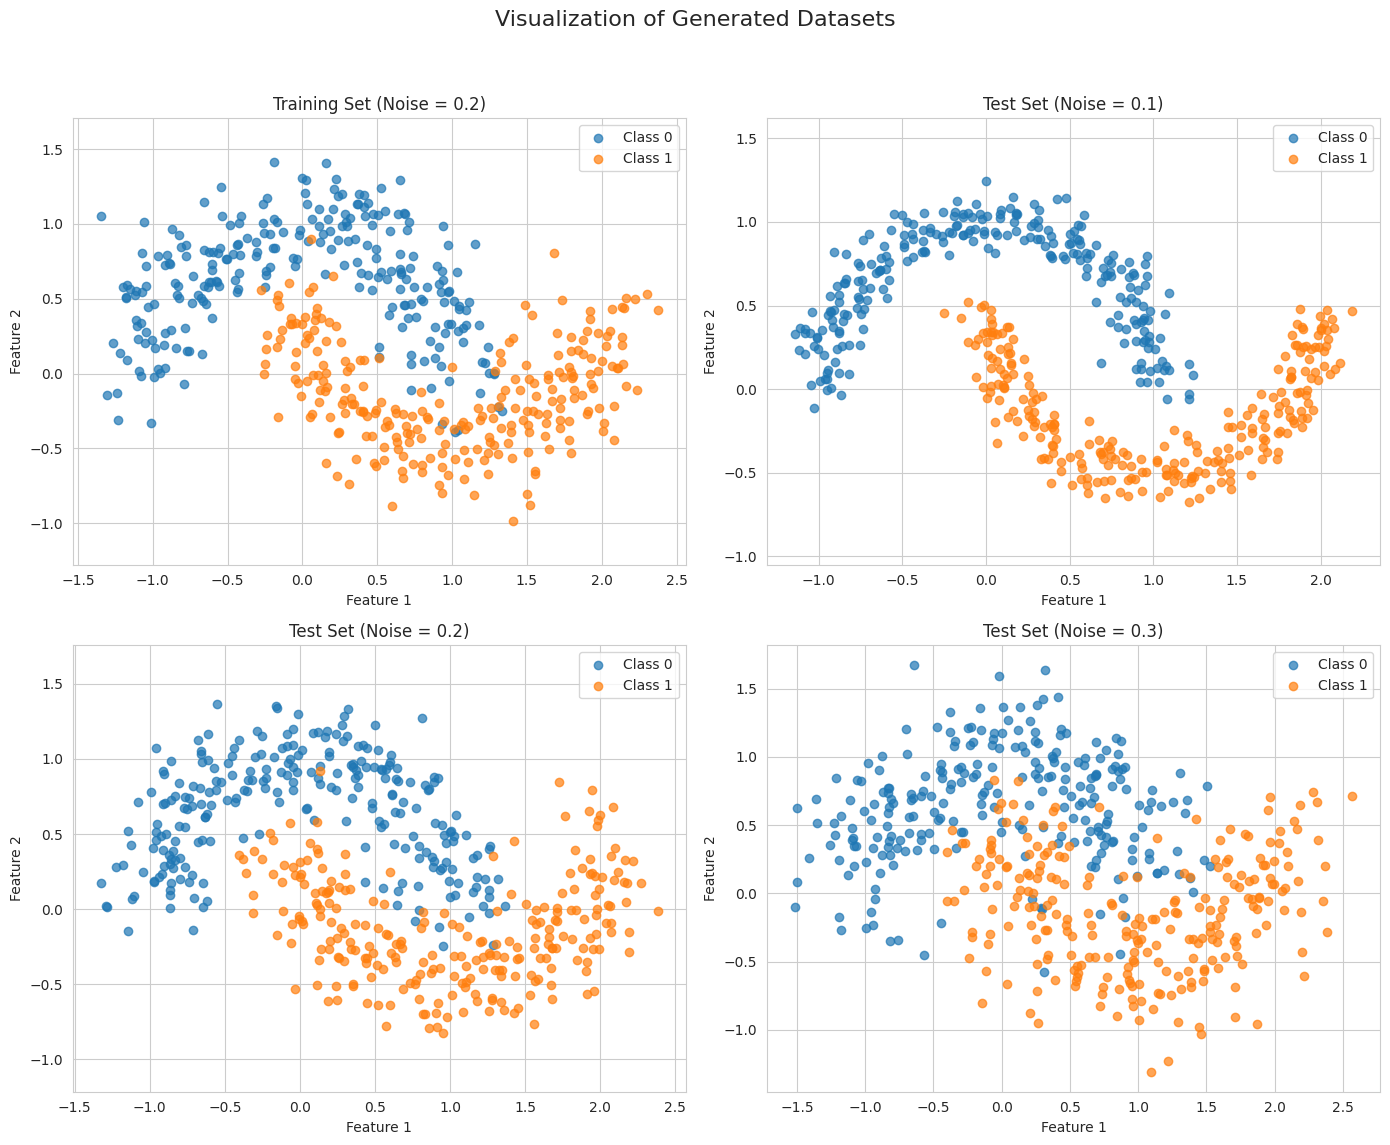

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Visualization of Generated Datasets', fontsize=16)

# plotting
def plot_dataset(ax, X, y, title):
    ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0', alpha=0.7)
    ax.scatter(X[y==1, 0], X[y==1, 1], label='Class 1', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.axis('equal')

# each dataset on a separate subplot
plot_dataset(axes[0, 0], X_train_raw, y_train_raw, 'Training Set (Noise = 0.2)')
plot_dataset(axes[0, 1], X_test_01, y_test_01, 'Test Set (Noise = 0.1)')
plot_dataset(axes[1, 0], X_test_02, y_test_02, 'Test Set (Noise = 0.2)')
plot_dataset(axes[1, 1], X_test_03, y_test_03, 'Test Set (Noise = 0.3)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# validation split from the training set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_raw, y_train_raw, test_size=0.2, random_state=seed, stratify=y_train_raw
)

In [9]:
scaler = StandardScaler()
# Fitting the scaler ONLY on the training data to learn mean and std
scaler.fit(X_train)

StandardScaler()

In [10]:
# Transform all datasets using the learned statistics
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

In [11]:
X_test_01_scaled[:10]

array([[ 0.800676  , -0.55699093],
       [ 0.54399792, -0.23168982],
       [ 0.60234512, -0.35168742],
       [ 0.63593291, -0.21498254],
       [ 0.47535982, -0.36160405],
       [ 0.65367787, -0.55650431],
       [ 0.66983121, -0.21579089],
       [ 0.64963752, -0.17792992],
       [ 0.80521555, -0.49601384],
       [ 0.82708772, -0.27192131]])

In [12]:
# Convert all data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1).to(device)
X_test_01_tensor = torch.FloatTensor(X_test_01_scaled).to(device)
y_test_01_tensor = torch.FloatTensor(y_test_01).view(-1, 1).to(device)
X_test_02_tensor = torch.FloatTensor(X_test_02_scaled).to(device)
y_test_02_tensor = torch.FloatTensor(y_test_02).view(-1, 1).to(device)
X_test_03_tensor = torch.FloatTensor(X_test_03_scaled).to(device)
y_test_03_tensor = torch.FloatTensor(y_test_03).view(-1, 1).to(device)
print(f"Shape of X_test_02_tensor: {X_test_02_tensor.shape}")
print(f"Mean of X_test_02_tensor[:, 0]: {X_test_02_tensor[:, 0].mean():.4f}")
print(f"Std of X_test_02_tensor[:, 0]: {X_test_02_tensor[:, 0].std():.4f}")

Shape of X_test_02_tensor: torch.Size([500, 2])
Mean of X_test_02_tensor[:, 0]: 0.0113
Std of X_test_02_tensor[:, 0]: 0.9992


In [13]:
print(f"Final training set size: {X_train_tensor.shape[0]}")
print(f"Validation set size: {X_val_tensor.shape[0]}")

Final training set size: 400
Validation set size: 100


MLP architecture

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # the layers of the network
        self.layer1 = nn.Linear(input_size, hidden_size) # Input to hidden layer
        self.relu = nn.ReLU() # Activation function
        self.layer2 = nn.Linear(hidden_size, output_size) # Hidden to output layer

    def forward(self, x):
        # the forward pass
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# function to count the model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
# Master training function
def train_model(model, X_train, y_train, X_val, y_val, l1_lambda=0.0, patience=50, epochs=1000, lr=0.01, weight_decay=0.0):
    # Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss() # Numerically stable loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # weight_decay is PyTorch's L2 regularization

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Training loop with progress bar
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train() # Set model to training mode

        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Add L1 regularization penalty if specified
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

        # Backward pass and optimization
        optimizer.zero_grad() # Clear previous gradients
        loss.backward() # Compute gradients
        optimizer.step() # Update weights

        # Validation phase
        model.eval() # Set model to evaluation mode
        with torch.no_grad(): # Disable gradient computation
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict()) # Save the best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load the best model state before returning
    model.load_state_dict(best_model_state)
    return model

In [19]:
# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, ax, title):
    model.eval() # Set the model to evaluation mode

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Make predictions on the grid
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = torch.sigmoid(Z).cpu().numpy().reshape(xx.shape)

    # Plot the contour and the data points
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.RdYlBu)
    ax.set_title(title)
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')

MLP with early stopping

In [20]:
print("Training Model for MLP with Early Stopping")
# initialise
mlp_early_stopping = MLP(input_size=2, hidden_size=32, output_size=1).to(device)

# training
mlp_early_stopping = train_model(
    model=mlp_early_stopping,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    patience=20
)
print("Model training complete.")

Training Model for MLP with Early Stopping


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 290
Model training complete.


MLP with L1 Regularisation

In [22]:
print("\nTraining Model for MLP with L1 Regularization (Grid Search)")

# Define the grid of L1 lambda values to search
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
best_l1_auroc = 0
best_l1_model = None
best_lambda = None

# Loop through each lambda value
for l1_lambda in l1_lambdas:
    print(f"Training with L1 lambda = {l1_lambda}")
    # Initialize a new model for each lambda
    model = MLP(input_size=2, hidden_size=32, output_size=1).to(device)

    # Train the model with the current L1 lambda
    model = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, l1_lambda=l1_lambda, patience=20) # shorter patience for grid search

    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        val_preds = torch.sigmoid(model(X_val_tensor)).cpu().numpy()
        auroc = roc_auc_score(y_val, val_preds)

    # Calculate sparsity (percentage of weights close to zero)
    total_weights = 0
    zero_weights = 0
    for param in model.parameters():
        total_weights += param.numel()
        zero_weights += (param.abs() < 1e-4).sum().item()
    sparsity = (zero_weights / total_weights) * 100

    # Store results
    l1_results.append({'lambda': l1_lambda, 'auroc': auroc, 'sparsity': sparsity})

    # Keep track of the best model
    if auroc > best_l1_auroc:
        best_l1_auroc = auroc
        best_l1_model = model
        best_lambda = l1_lambda

mlp_l1 = best_l1_model
print(f"\nBest L1 Lambda: {best_lambda} with Validation AUROC: {best_l1_auroc:.4f}")



Training Model for MLP with L1 Regularization (Grid Search)
Training with L1 lambda = 1e-06


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 268
Training with L1 lambda = 3e-06


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 367
Training with L1 lambda = 1e-05


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 351
Training with L1 lambda = 3e-05


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 314
Training with L1 lambda = 0.0001


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 313
Training with L1 lambda = 0.0003


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 319

Best L1 Lambda: 0.0001 with Validation AUROC: 0.9980


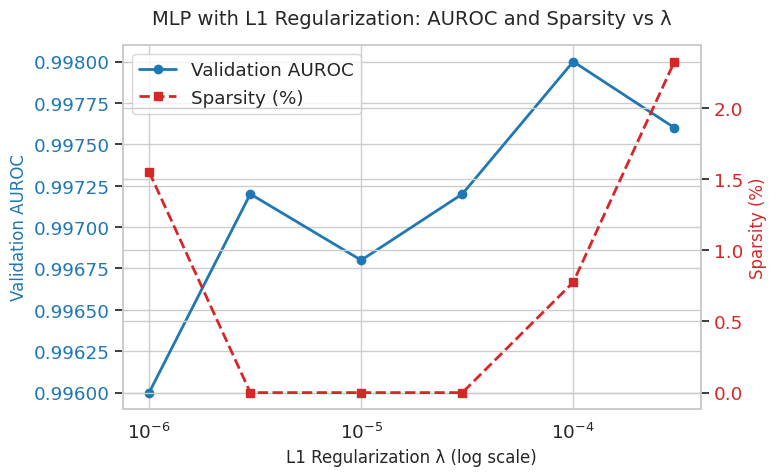

In [27]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)

l1_df = pd.DataFrame(l1_results)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot AUROC (left y-axis)
ax1.plot(l1_df['lambda'], l1_df['auroc'], marker='o', color='tab:blue', linewidth=2, label='Validation AUROC')
ax1.set_xlabel('L1 Regularization λ (log scale)', fontsize=12)
ax1.set_ylabel('Validation AUROC', color='tab:blue', fontsize=12)
ax1.set_xscale('log')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Sparsity (right y-axis)
ax2 = ax1.twinx()
ax2.plot(l1_df['lambda'], l1_df['sparsity'], marker='s', color='tab:red', linestyle='--', linewidth=2, label='Sparsity (%)')
ax2.set_ylabel('Sparsity (%)', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title & combined legend
plt.title('MLP with L1 Regularization: AUROC and Sparsity vs λ', fontsize=14, pad=15)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best', frameon=True)

fig.tight_layout()
plt.show()

MLP with L2 Regularisation

In [28]:
print("\nTraining Model for MLP with L2 Regularization (Grid Search)")

# Define the grid of L2 weight decay values
l2_decays = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
best_l2_auroc = 0
best_l2_model = None
best_decay = None

# Loop through each weight decay value
for decay in l2_decays:
    print(f"Training with L2 weight_decay = {decay}")
    # Initialize a new model
    model = MLP(input_size=2, hidden_size=32, output_size=1).to(device)

    # Train the model with the current weight_decay
    model = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, weight_decay=decay, patience=20)

    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        val_preds = torch.sigmoid(model(X_val_tensor)).cpu().numpy()
        auroc = roc_auc_score(y_val, val_preds)

    # Keep track of the best model
    if auroc > best_l2_auroc:
        best_l2_auroc = auroc
        best_l2_model = model
        best_decay = decay

mlp_l2 = best_l2_model
print(f"\nBest L2 weight_decay: {best_decay} with Validation AUROC: {best_l2_auroc:.4f}")


Training Model for MLP with L2 Regularization (Grid Search)
Training with L2 weight_decay = 1e-05


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 314
Training with L2 weight_decay = 0.0001


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 322
Training with L2 weight_decay = 0.001


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 347
Training with L2 weight_decay = 0.01


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 403
Training with L2 weight_decay = 0.1


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 68
Training with L2 weight_decay = 1.0


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Early stopping triggered at epoch 32

Best L2 weight_decay: 0.001 with Validation AUROC: 0.9972


Logistic Regression with polynomial features

In [30]:
print("\n--- Training Model for Logistic Regression with Polynomial Features ---")

# Create polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False)
# Fit on the (scaled) training data
poly.fit(X_train_scaled)

# Transform all datasets
X_train_poly = poly.transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_01_poly = poly.transform(X_test_01_scaled)
X_test_02_poly = poly.transform(X_test_02_scaled)
X_test_03_poly = poly.transform(X_test_03_scaled)

# Convert to tensors
X_train_poly_tensor = torch.FloatTensor(X_train_poly).to(device)
X_val_poly_tensor = torch.FloatTensor(X_val_poly).to(device)
X_test_01_poly_tensor = torch.FloatTensor(X_test_01_poly).to(device)
X_test_02_poly_tensor = torch.FloatTensor(X_test_02_poly).to(device)
X_test_03_poly_tensor = torch.FloatTensor(X_test_03_poly).to(device)

# define the Logistic Regression model
# just an MLP with no hidden layer
input_dim_poly = X_train_poly.shape[1]
log_reg_poly = nn.Linear(input_dim_poly, 1).to(device)

# We need a custom training loop since the plot_decision_boundary expects a standard model
# We wrap it in a nn.Module to be compatible
class PolyLogReg(nn.Module):
    def __init__(self, poly_transformer, model):
        super().__init__()
        self.poly = poly_transformer
        self.model = model

    def forward(self, x):
        # This is tricky because the input 'x' is un-transformed
        # We need to apply scaling and polynomial transformation first
        # For simplicity in plotting, we will train it normally and plot carefully
        return self.model(x)

# Train the model
log_reg_poly_trained_layer = train_model(
    model=log_reg_poly,
    X_train=X_train_poly_tensor,
    y_train=y_train_tensor,
    X_val=X_val_poly_tensor,
    y_val=y_val_tensor,
    patience=50
)

# Create a final wrapper model for easy prediction and plotting
class FullPolyModel(nn.Module):
    def __init__(self, scaler, poly, model_layer):
        super().__init__()
        self.scaler = scaler
        self.poly = poly
        self.model_layer = model_layer

    def forward(self, x):
        # Ensure input is a numpy array for transformers
        if isinstance(x, torch.Tensor):
            x_np = x.cpu().numpy()
        else:
            x_np = x

        # Apply the full pipeline
        x_scaled = self.scaler.transform(x_np)
        x_poly = self.poly.transform(x_scaled)
        x_tensor = torch.FloatTensor(x_poly).to(device)

        return self.model_layer(x_tensor)

log_reg_poly_final = FullPolyModel(scaler, poly, log_reg_poly_trained_layer)

print("Model 4 training complete.")


--- Training Model for Logistic Regression with Polynomial Features ---


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Model 4 training complete.


In [31]:
models = {
    "MLP (Early Stop)": mlp_early_stopping,
    "MLP (L1)": mlp_l1,
    "MLP (L2)": mlp_l2,
    "Logistic Regression (Poly)": log_reg_poly_final
}

test_sets = {
    "Test Accuracy (Noise 0.10)": (X_test_01_tensor, y_test_01_tensor),
    "Test Accuracy (Noise 0.20)": (X_test_02_tensor, y_test_02_tensor),
    "Test Accuracy (Noise 0.30)": (X_test_03_tensor, y_test_03_tensor)
}

# logistic regression model uses polynomial features as input
test_sets_poly = {
    "Test Accuracy (Noise 0.10)": (X_test_01_poly_tensor, y_test_01_tensor),
    "Test Accuracy (Noise 0.20)": (X_test_02_poly_tensor, y_test_02_tensor),
    "Test Accuracy (Noise 0.30)": (X_test_03_poly_tensor, y_test_03_tensor)
}


results = []

for name, model in models.items():
    model.eval()
    row = {}

    # parameter count
    if name == "Logistic Regression (Poly)":
        # actual trainable part is just the linear layer
        row["Parameter Count"] = count_parameters(model.model_layer)
        current_test_sets = test_sets_poly
        # input to the trainable layer is already transformed
        predictor = model.model_layer
    else:
        row["Parameter Count"] = count_parameters(model)
        current_test_sets = test_sets
        predictor = model

    # evaluate on each test set
    for acc_name, (X_test, y_test) in current_test_sets.items():
        with torch.no_grad():
            outputs = predictor(X_test)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            accuracy = accuracy_score(y_test.cpu(), preds.cpu())
            row[acc_name] = f"{accuracy:.2%}" # Format as percentage

    results.append(row)

# create a pandas DataFrame for nice display
results_df = pd.DataFrame(results, index=models.keys())
print("--- Performance and Robustness Evaluation ---")
display(results_df)

--- Performance and Robustness Evaluation ---


,Parameter Count,Test Accuracy (Noise 0.10),Test Accuracy (Noise 0.20),Test Accuracy (Noise 0.30)
MLP (Early Stop),129,100.00%,96.40%,90.60%
MLP (L1),129,100.00%,96.40%,90.80%
MLP (L2),129,100.00%,96.40%,91.20%
Logistic Regression (Poly),10,100.00%,96.00%,91.80%


Decision Boundaries

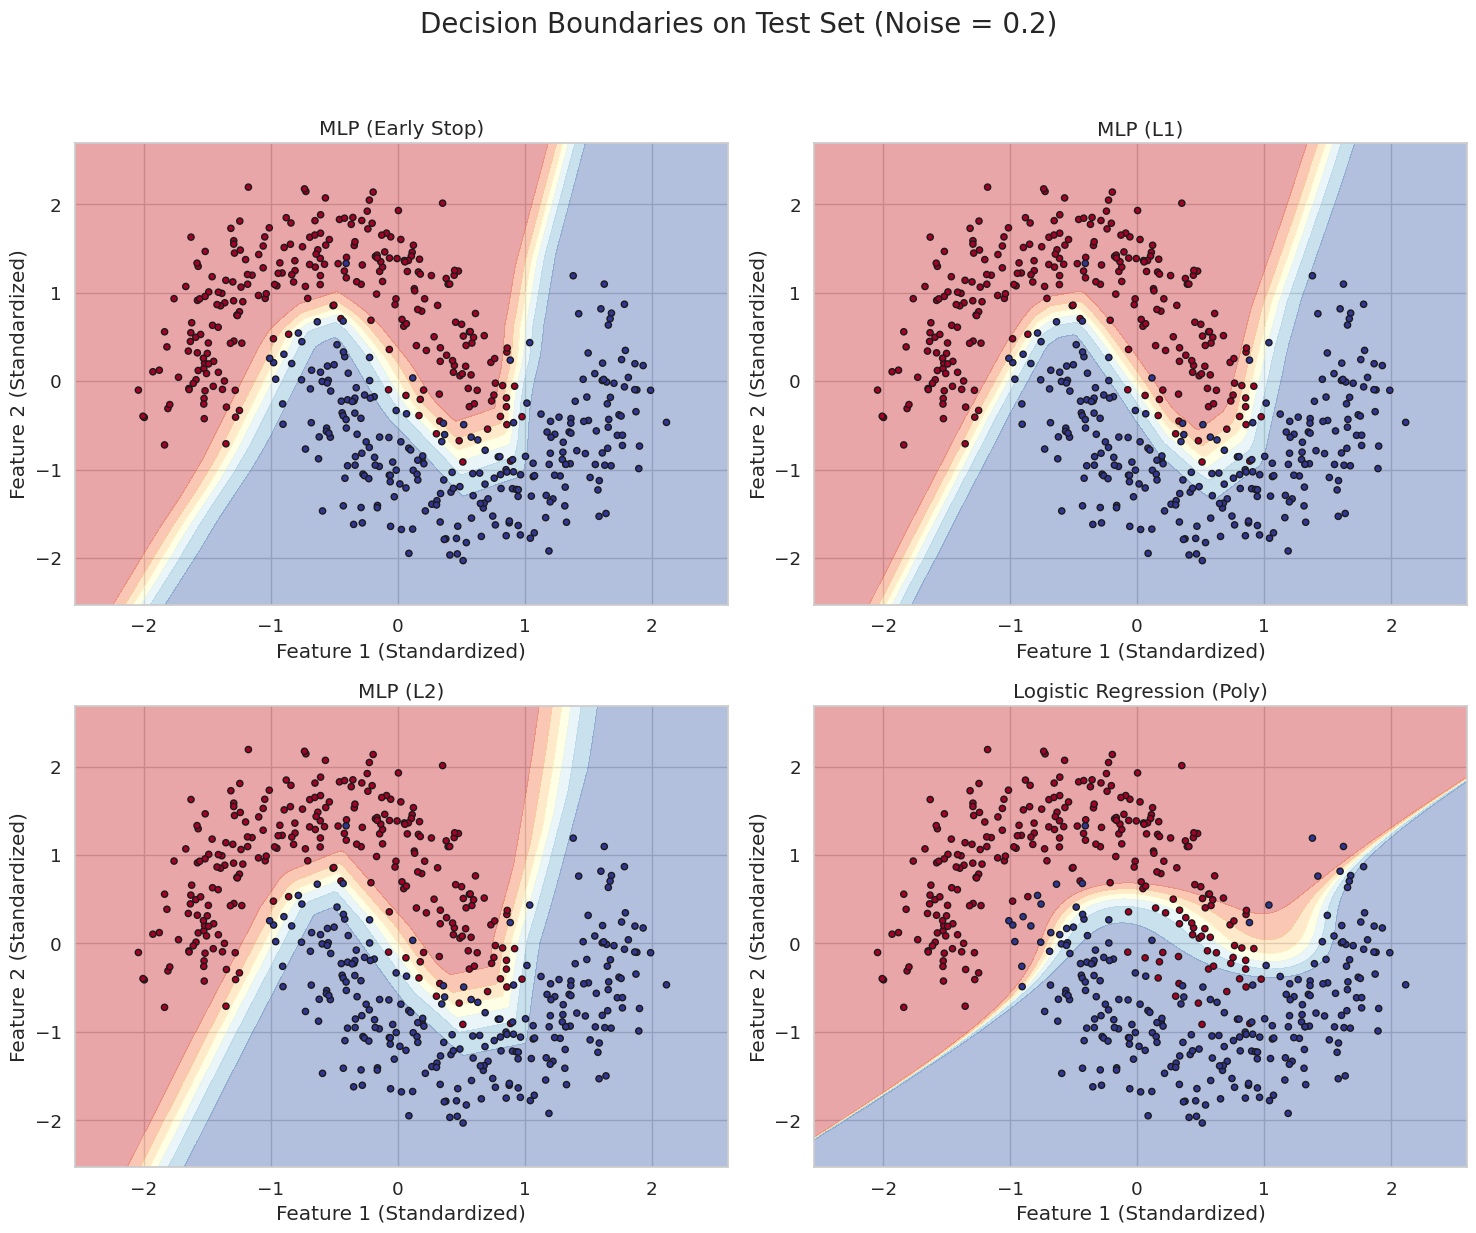

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
fig.suptitle('Decision Boundaries on Test Set (Noise = 0.2)', fontsize=20)
axes = axes.ravel()

# Data to plot (original, unscaled for better interpretation)
X_plot, y_plot = X_test_02_scaled, y_test_02

# Plot for each model
for i, (name, model) in enumerate(models.items()):
    # We pass the scaled data to the plotting function
    # The plotting function creates a grid in the scaled space
    if name == "Logistic Regression (Poly)":
        # The final poly model handles scaling internally for the plot
        plot_decision_boundary(model, X_plot, y_plot, axes[i], name)
    else:
        # For MLPs, we need to wrap them to use the scaled data
        # For simplicity, we can plot using the already scaled test data
        plot_decision_boundary(model, X_test_02_scaled, y_test_02, axes[i], name)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Effect of L1 Regularization:

Sparsity: L1 (Lasso) pushes some weights exactly to zero, making the model sparse and simpler by effectively removing less useful features or connections.

Boundary Jaggedness: It can create sharper, more axis-aligned, and sometimes jagged decision boundaries due to zeroed weights.

Effect of L2 Regularization:

Smoothness: L2 (Ridge) keeps weights small but non-zero, leading to smoother and more stable decision boundaries.

Margin: It encourages larger margins between classes, improving generalization.

### Introducing Class Imbalance

In [33]:
# Introduce class imbalance (70:30) in the training set

# Separate classes in the original training data
X_train_class_0 = X_train_raw[y_train_raw == 0]
X_train_class_1 = X_train_raw[y_train_raw == 1]

# Determine the number of samples for each class in the imbalanced set
n_samples_total = X_train_raw.shape[0]
n_samples_class_0 = int(n_samples_total * 0.7)
n_samples_class_1 = n_samples_total - n_samples_class_0 # The remaining samples for class 1

# Randomly sample from each class to create the imbalanced set
# Ensure we don't sample more than available
n_samples_class_0 = min(n_samples_class_0, X_train_class_0.shape[0])
n_samples_class_1 = min(n_samples_class_1, X_train_class_1.shape[0])


# Use numpy.random.choice for sampling with replacement if needed, or without if not
# For this case, let's assume we have enough samples and sample without replacement
# If not enough samples, you might need to handle this (e.g., with replacement or an error)

# Shuffle and select
np.random.shuffle(X_train_class_0)
np.random.shuffle(X_train_class_1)

X_train_imbalanced_raw = np.vstack([X_train_class_0[:n_samples_class_0], X_train_class_1[:n_samples_class_1]])
y_train_imbalanced_raw = np.hstack([np.zeros(n_samples_class_0), np.ones(n_samples_class_1)])

# Shuffle the imbalanced dataset
shuffle_idx = np.random.permutation(n_samples_class_0 + n_samples_class_1)
X_train_imbalanced_raw = X_train_imbalanced_raw[shuffle_idx]
y_train_imbalanced_raw = y_train_imbalanced_raw[shuffle_idx]

print(f"Shape of imbalanced training X: {X_train_imbalanced_raw.shape}")
print(f"Shape of imbalanced training y: {y_train_imbalanced_raw.shape}")
print(f"Class distribution in imbalanced training set: Class 0 = {np.sum(y_train_imbalanced_raw == 0)}, Class 1 = {np.sum(y_train_imbalanced_raw == 1)}")

# Now, create the validation split from this imbalanced training data
X_train_imb, X_val_imb, y_train_imb, y_val_imb = train_test_split(
    X_train_imbalanced_raw, y_train_imbalanced_raw, test_size=0.2, random_state=seed, stratify=y_train_imbalanced_raw
)

# Standardize the imbalanced training and validation sets using the original scaler fitted on balanced data
X_train_imb_scaled = scaler.transform(X_train_imb)
X_val_imb_scaled = scaler.transform(X_val_imb)

# Convert to tensors
X_train_imb_tensor = torch.FloatTensor(X_train_imb_scaled).to(device)
y_train_imb_tensor = torch.FloatTensor(y_train_imb).view(-1, 1).to(device)
X_val_imb_tensor = torch.FloatTensor(X_val_imb_scaled).to(device)
y_val_imb_tensor = torch.FloatTensor(y_val_imb).view(-1, 1).to(device)

print(f"Final imbalanced training set size: {X_train_imb_tensor.shape[0]}")
print(f"Imbalanced validation set size: {X_val_imb_tensor.shape[0]}")

Shape of imbalanced training X: (400, 2)
Shape of imbalanced training y: (400,)
Class distribution in imbalanced training set: Class 0 = 250, Class 1 = 150
Final imbalanced training set size: 320
Imbalanced validation set size: 80


Effect of Class Imbalance:

Accuracy: Can be misleading, as models may favor the majority class.

AUROC: A better metric since it measures class separation regardless of imbalance.